In [19]:
import numpy as np
import matplotlib.pyplot as plt

from maze_dataset import (
    MazeDatasetConfig,
    LatticeMazeGenerators,
    MazeDataset,
    LatticeMaze,
    CoordTup,
)
from maze_dataset.maze import TargetedLatticeMaze

In [20]:
def iterated_backfilling(maze: TargetedLatticeMaze) -> TargetedLatticeMaze:
    """
    Perform iterated backfilling on a TargetedLatticeMaze object.

    This algorithm iteratively removes dead ends (nodes with only one neighbor)
    that are not the start or target nodes until no more such nodes exist.

    Args:
    maze (TargetedLatticeMaze): The input maze to perform backfilling on.

    Returns:
    TargetedLatticeMaze: A new TargetedLatticeMaze object with dead ends removed.
    """

    # Create a copy of the connection list to modify
    new_connection_list = maze.connection_list.copy()

    # Create a temporary TargetedLatticeMaze object for using its methods
    temp_maze = TargetedLatticeMaze(
        connection_list=new_connection_list,
        start_pos=maze.start_pos,
        end_pos=maze.end_pos,
    )

    changed = True
    while changed:
        changed = False
        for i in range(maze.grid_shape[0]):
            for j in range(maze.grid_shape[1]):
                pos = (i, j)
                if _should_remove_node(temp_maze, pos):
                    _remove_node(new_connection_list, pos)
                    changed = True

        # Update the temporary maze with the new connection list
        temp_maze = TargetedLatticeMaze(
            connection_list=new_connection_list,
            start_pos=maze.start_pos,
            end_pos=maze.end_pos,
        )

    return TargetedLatticeMaze(
        connection_list=new_connection_list,
        start_pos=maze.start_pos,
        end_pos=maze.end_pos,
    )


def _should_remove_node(maze: TargetedLatticeMaze, pos: CoordTup) -> bool:
    """Check if a node should be removed."""
    if pos == tuple(maze.start_pos) or pos == tuple(maze.end_pos):
        return False

    neighbors = maze.get_coord_neighbors(np.array(pos))
    return len(neighbors) == 1


def _remove_node(connection_list: np.ndarray, pos: CoordTup) -> None:
    """Remove a node by disconnecting all its connections."""
    i, j = pos

    # Remove up connection
    if i > 0:
        connection_list[0, i - 1, j] = False
    # Remove down connection
    if i < connection_list.shape[1] - 1:
        connection_list[0, i, j] = False
    # Remove left connection
    if j > 0:
        connection_list[1, i, j - 1] = False
    # Remove right connection
    if j < connection_list.shape[2] - 1:
        connection_list[1, i, j] = False

In [21]:
cfg: MazeDatasetConfig = MazeDatasetConfig(
    name="test",  # name is only for you to keep track of things
    grid_n=10,  # number of rows/columns in the lattice
    n_mazes=4,  # number of mazes to generate
    maze_ctor=LatticeMazeGenerators.gen_dfs_percolation,  # algorithm to generate the maze
    maze_ctor_kwargs={"p": 0.01},  # keyword arguments to pass to the maze
)

# to create a dataset, just call MazeDataset.from_config
dataset: MazeDataset = MazeDataset.from_config(cfg)

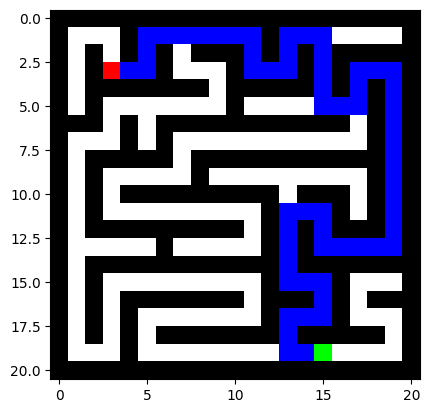

In [22]:
maze = dataset[0]
plt.imshow(maze.as_pixels())

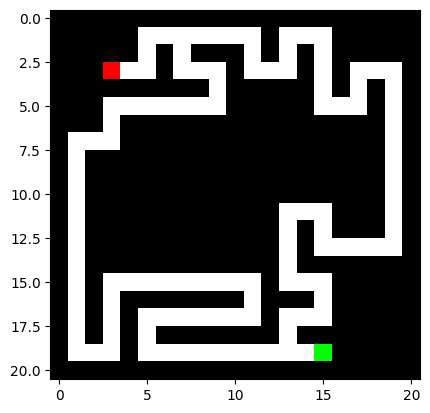

In [23]:
maze_bf = iterated_backfilling(maze)

from maze_dataset.maze.lattice_maze import (
    _remove_isolated_cells,
    _remove_isolated_cells_old,
)

plt.imshow(_remove_isolated_cells(maze_bf.as_pixels()))